# Poor_Att

## 1.5 - Students with Poor Attendance

### This ipynb carries out the same task as the Poor_Att_Merged ipynb. The only difference is that this notebook finds the department and student averages for one module at a time, in order to create a poor attendance dataframe and visualisation for the user specified module.

## Task Description

Write a Python program to use attendance records in the database and find out
a list of students with poor attendance. You should come up with the details of
the criteria to identify those students. For example, if the average attendance of
a student in the current semester is much less than the department average, then
student id should be included in the list.
Student IDs must be sorted by their average attendance. The list should include
the weekly attendance. The program should highlight the attendance of a student
in a week if it is higher than the department average.Additionally, the program appropriately visualises the weekly attendance records
of each module and student.
Save the program as Poor_Att.ipynb.

Firstly, necessary modules are imported into the notebook.

In [1]:
# Import modules
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Define Variables

In [2]:
def define_variables_3():
    """
    This function prompts the user to enter a module code.
    
    Args:
    None
    
    Returns:
    module_code (str): Users input for each variable.
    """
    module_code = input("Enter a module code (e.g. 22COA122ModuleRegister,\n\
    22COA111ModuleRegister):")
    return(module_code)

## Read data from sql database

In [23]:
def read_sql_to_pd(module_code):
    """
    This function takes in the module code, connects to the SQLite database,
    and reads the attendance and sessions tables for that module, storing them
    into two separate dataframes 'df_att' and 'df_ssn' respectively.
    There is also a validity check code to ensure the user inputs a valid
    module code with the required format.
    
    Args:
    module_code (str): Module code entered by the user.
    
    Returns:
    df_att, df_ssn (pd.DataFrame): Dataframes containing attendance and session
    data for given module code.
    """
    conn = sqlite3.connect("CWDatabase.db")
    try:
        df_att = pd.read_sql(f"SELECT * FROM '{module_code}_attendance'",
                             conn, index_col = ['s_id'])
        df_ssn = pd.read_sql(f"SELECT * FROM '{module_code}_sessions'",
                             conn, index_col = ['s_id'])
    except sqlite3.OperationalError:
        print(f"Error: No table for module code '{module_code}' \n\
        found in the database.")
    conn.close()
    return(df_att, df_ssn)

## Modify and merge Attendance & Sessions dataframes

Note: While the initial dataframe has Na values for students who have authorised absences, I have opted to use fillna(0) to view these as absent regardless of the circumstances. While I understand that this is not the most optimal method, this is the logic I have used in order to determine how the students attendances are calculated.

This same logic will be used consistently throughout the entire notebook.

In [4]:
def merged_df(df_att, df_ssn):
    """
    This function takes in two dataframes for attendance and session data.
    It tranposes df_att, fills Na with 0, ensures s_id is seen in integer
    format, and then merges the attendance and session tables using the 
    common index of 's_id'.
    
    Args:
    df_att, df_ssn (pd.DataFrame): Dataframes containing attendance and
    sessions data respectively.
    
    Returns:
    stu_week_att (pd.DataFrame): Dataframe containing merged dataframe.
    """
    # transpose attendance dataframe
    df_att = df_att.T

    #fill na with 0 so NaN does not hinder avg calculation
    df_att = df_att.fillna(0)

    # make the 's_id' in integer format
    df_att.index = df_att.index.astype(int)
    df_ssn.index = df_ssn.index.astype(int)

    # merge both dataframes
    stu_week_att = pd.merge(df_att, df_ssn,
                            left_index=True, right_index=True, how='inner')

    # ensure index is still labelled correctly
    stu_week_att = stu_week_att.rename_axis('s_id', axis = 0)
    return(stu_week_att)

## Append weekly, student and departmental averages

In [5]:
def stu_week_module(stu_week_att):
    """
    This function finds the weekly mean attendance of students in % by
    grouping by week and taking the mean for each week, saving into a new
    pandas dataframe.
    After modifying the new dataframe, it adds a new row to find student average
    over the length of the module.
    It also adds a new column showing weekly average for all students.
    
    Args:
    stu_week_att (pd.DataFrame): Dataframe containing merged dataframe
    of attendance and session data.
    
    Returns:
    stu_avg_module (pd.DataFrame): New dataframe showing weekly averages
    for all students, as well as overall weekly average, and overall student
    average.
    """
    #find weekly mean attendance in percentages
    stu_avg_module = stu_week_att.groupby('Week').mean().mul(100)
    
    stu_avg_module = stu_avg_module.T
    
    stu_avg_module.index.names = ['s_id']
    # add new column for average student attendance over all weeks
    stu_avg_module['stu_avg'] = stu_avg_module.mean(axis = 1)
    # add new row for overall weekly attendance for all students
    stu_avg_module.loc['wkly_avg'] = stu_avg_module.mean()
    return(stu_avg_module)

## Find the criterion value

In [6]:
def poor_att_criteria(stu_avg_module):
    """
    This function finds the overall department average by identifying
    the last value in the final row and column of the dataframe above.
    
    Args:
    stu_avg_module (pd.DataFrame): Dataframe showing weekly averages
    for all students, as well as overall weekly average, and overall student
    average.
    
    Returns:
    dept_avg (float): Departmental average attendance value.
    """
    dept_avg = stu_avg_module.iloc[-1,-1]
    return(dept_avg)

## Create a new df for poor attendance students

To filter for students that have 'poor' attendance, it is first important to define what poor attendance is. The criteria that has been set is, a student is considered to have poor attendance if their overall average attendance for all weeks in the semester, is less than half the departmental average attendance over the semester.

In [7]:
def poor_att_stu_df(stu_avg_module, dept_avg):
    """
    This function creates a new DataFrame (poor_att_df) which filters 
    the previous dataframe to only show students who have poor attendance
    according to the set criteria above.
    It then sorts the attendance in ascending order.
    
    Args:
    stu_avg_module (pd.DataFrame): Dataframe showing weekly averages
    for all students, as well as overall weekly average, and overall student
    average.
    dept_avg (float): Departmental average attendance value.
    
    Returns:
    poor_att_df (pd.DataFrame): DataFrame containing poor attendance
    students' weekly and overall average attendances.
    """
    # create a new df which filters for poor att students
    poor_att_df = stu_avg_module.loc[stu_avg_module['stu_avg'] < dept_avg/2]
    # Sort the rows by the "stu_avg" column in ascending order
    poor_att_df = poor_att_df.sort_values('stu_avg', ascending=True)
    return(poor_att_df)

## Defining a colour code

In [8]:
def highlight_attendance_2(value, dept_avg):
    """
    This function assigns a colour to the values in the poor attendance
    dataframe. It will highlight any values green if they are above the
    departmental average value.
    
    Args:
    value (float): Values to compare to the dept_avg.
    dept_avg (float): Departmental average attendance value.
    
    Returns:
    str: Assign green colour to values above dept_avg.
    """
    if value > dept_avg:
        color = 'green'
    else:
        color = ''
    return f'background-color: {color}'

## Randomly selecting data to plot a figure

In [9]:
def random_student_select(stu_avg_module, poor_att_df):
    """
    This function sets a seed, and takes a random sample of 5
    students from the poor_att_df dataframe to make a new 
    dataframe called stu_random.
    
    Args:
    stu_avg_module (pd.DataFrame): DataFrame containing weekly mean
    attendance and overall attendance of all students.
    poor_att_df (pd.DataFrame): DataFrame containing attendance data
    for all students who have poor attendance according to the criteria.
    
    Returns:
    stu_random (pd.DataFrame): A dataframe containing a random sample
    of 5 students' weekly attendance data, obtained from poor_att_df.
    wkly_avg_module (float): The overall weekly average attendances for 
    the module.
    """
    # Obtain avg weekly att for the all students in the module
    wkly_avg_module = stu_avg_module.iloc[-1]
    
    # Set a seed
    np.random.seed(12) #remove line if you want new values every run
    
    # Create a new df which takes a random sample of 5 from poor_att_df
    stu_random = poor_att_df.sample(n = 5)
    # add the weekly avg attendance for the module
    stu_random = stu_random.append(wkly_avg_module)
    # Remove the final column which is not needed for the plot
    stu_random = stu_random.drop(stu_random.columns[-1], axis = 1)
    return(stu_random, wkly_avg_module)

## Create visualisation

In [10]:
def poor_att_graph(stu_random, module_code):
    """
    This function creates a scatterplot and a line plot on the same figure.
    The line plot shows the average weekly attendance overall for the department.
    The scatterplot loops through each student to plot their average weekly attendance
    where each student has a different colour point.
    A random jitter is used to visualise overlapping points better.
    
    Args:
    stu_random (pd.DataFrame): A dataframe containing a random sample of 5
    students from poor_att_df, with their overall weekly average attendance.
    module_code (str): User defined module code.
    
    Returns:
    None
    """
    # plot the line
    x = range(1, stu_random.shape[1] + 1)
    y1 = stu_random.loc['wkly_avg']
    
    # plot the scatter

    colors = ['b', 'g', 'r', 'c', 'm']

    for i, (index, row) in enumerate(stu_random.iloc[:-1].iterrows()):
        x_jitter = np.random.uniform(-0.1, 0.1, size = len(x))
        y_jitter = np.random.uniform(-0.1, 0.1, size = len(row))
        plt.scatter(x + x_jitter, row + y_jitter,
                    color=colors[i % len(colors)],label = index)

    plt.plot(x,y1, label = 'dept_avg')


    plt.xlabel('Week')
    plt.ylabel('Average Attendance %')
    plt.title(f'Weeky Attendance for Students with Poor Attendance in \n\
    {module_code}')
    plt.legend(loc = 'upper right')
    plt.xticks(x)
    # Show the plot
    plt.show()

## Main Code

In [11]:
def main_poor_att():
    """
    This function is the main function that calls all the other functions
    previously created in this notebook.
    It then uses a styler to apply the colour coding function to poor_att_df
    to highlight students attendance if it is higher than department average.
    It then displays the random sample dataframe, and plots the visualisation.
    
    Args:
    None
   
    Returns:
    None
    """
    module_code = define_variables_3()
    df_att, df_ssn = read_sql_to_pd(module_code)
    stu_week_att = merged_df(df_att, df_ssn)
    stu_avg_module = stu_week_module(stu_week_att)
    dept_avg = poor_att_criteria(stu_avg_module)
    poor_att_df = poor_att_stu_df(stu_avg_module, dept_avg)
    
    # using highlight_attendance function
    print(f"\nAttendance record for Students with poor attendance:")
    poor_att_df_colour = poor_att_df.style.applymap \
    (lambda x:highlight_attendance_2(x, dept_avg))
    
    display(poor_att_df_colour)
    
    stu_random, wkly_avg_module = random_student_select(stu_avg_module,
                                                        poor_att_df)
    
    print(f"\nAttendance record for random sample of students with low \n\
    attendance:")
    display(stu_random)
    
    poor_att_vis = poor_att_graph(stu_random, module_code)

## Main Test Code 1 - 22COA122

Running the main function will give the following output in this order:

A poor attendance dataframe, colour coded green for good attendance points in the table.

A dataframe of a random sample of 5 students, as well as the overall weekly average for all students in the module.

A graph showing all 5 students' weekly data as a scatter, and the module wide weekly average as a line plot.

Enter a module code (e.g. 22COA122ModuleRegister,
    22COA111ModuleRegister):22COA122ModuleRegister

Attendance record for Students with poor attendance:


Week,W1,W2,W3,W4,W5,W6,stu_avg
s_id,,,,,,,
18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,33.333333,0.000000,0.000000,0.000000,0.000000,0.000000,5.555556
24,0.000000,0.000000,0.000000,0.000000,33.333333,0.000000,5.555556



Attendance record for random sample of students with low 
    attendance:


Week,W1,W2,W3,W4,W5,W6
s_id,,,,,,
70,33.333333,0.000000,0.000000,0.000000,0.000000,0.00000
150,66.666667,33.333333,0.000000,0.000000,33.333333,0.00000
101,33.333333,0.000000,33.333333,25.000000,0.000000,0.00000
31,66.666667,33.333333,0.000000,0.000000,33.333333,0.00000
24,0.000000,0.000000,0.000000,0.000000,33.333333,0.00000
wkly_avg,52.596315,46.901173,46.566164,49.748744,42.211055,76.38191


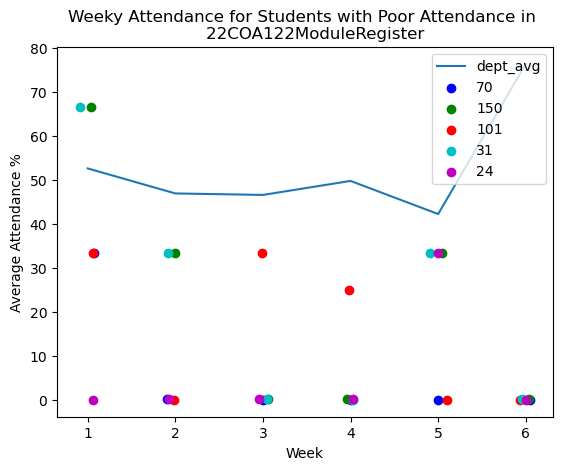

In [12]:
main_poor_att()
# use 22COA122ModuleRegister

## Main Test Code 2 - 22COA111

Enter a module code (e.g. 22COA122ModuleRegister,
    22COA111ModuleRegister):22COA111ModuleRegister

Attendance record for Students with poor attendance:


Week,W1,W2,W3,W4,W5,stu_avg
s_id,,,,,,
18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
169,0.000000,33.333333,0.000000,0.000000,0.000000,6.666667
31,0.000000,0.000000,0.000000,0.000000,50.000000,10.000000



Attendance record for random sample of students with low 
    attendance:


Week,W1,W2,W3,W4,W5
s_id,,,,,
169,0.00000,33.333333,0.000000,0.000000,0.000000
24,50.00000,0.000000,0.000000,0.000000,0.000000
154,0.00000,0.000000,100.000000,0.000000,50.000000
82,0.00000,66.666667,0.000000,50.000000,0.000000
50,50.00000,0.000000,0.000000,0.000000,50.000000
wkly_avg,67.58794,50.083752,69.346734,69.095477,69.346734


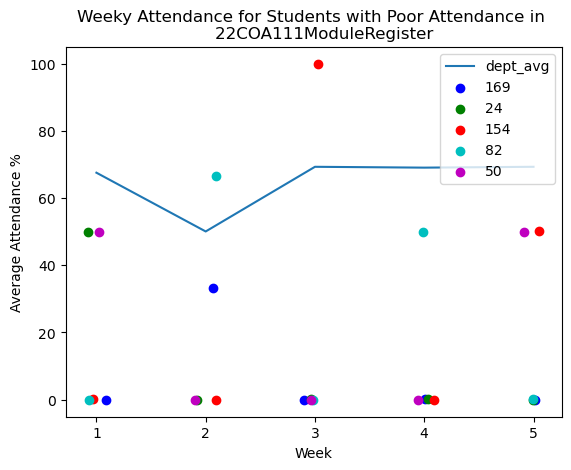

In [13]:
main_poor_att()
# use 22COA111ModuleRegister

# Testing all functions in the Notebook

Running the function (define_variables_3) prompts the user to enter a valid module code. Printing the module_code variable verifies that the user input has been assigned to the variable.

In [14]:
module_code = define_variables_3()
print(module_code)

Enter a module code (e.g. 22COA122ModuleRegister,
    22COA111ModuleRegister):22COA111ModuleRegister
22COA111ModuleRegister


Running the function (read_sql_to_pd), displays the attendance and sessions table (in that order) for the given module code. These tables are obtained through the SQLite database.

In [15]:
df_att, df_ssn = read_sql_to_pd(module_code)
display(df_att, df_ssn)

,1,2,3,4,5,6,8,9,11,12,14
s_id,,,,,,,,,,,
0,1.0,1.0,0.0,None,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,None,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,None,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,NaN,NaN,1.0,None,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,None,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
238,0.0,0.0,1.0,None,1.0,0.0,1.0,1.0,1.0,1.0,1.0
239,1.0,0.0,1.0,None,1.0,1.0,1.0,1.0,1.0,1.0,0.0
240,1.0,1.0,1.0,None,1.0,0.0,1.0,1.0,1.0,1.0,1.0


,Week,Day,Time,Lesson,Room,Excluded,Semester
s_id,,,,,,,
1,W1,Monday (03-10-2022),09:00 - 10:00,Lecture,U020,,S1
2,W1,Wednesday (05-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
3,W2,Wednesday (12-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
4,W2,Wednesday (12-10-2022),12:00 - 13:00,Tutorial,,,S1
5,W2,Thursday (13-10-2022),14:00 - 15:00,Lecture,CC011,,S1
6,W3,Wednesday (19-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
7,W3,Wednesday (19-10-2022),12:00 - 13:00,Tutorial,,,S1
8,W3,Thursday (20-10-2022),14:00 - 15:00,Lecture,CC011,,S1
9,W4,Wednesday (26-10-2022),10:00 - 11:00,Lecture,SMB014,,S1


Running the function (merged_df) creates a merged dataframe containing both attendance and sessions tables in one single table as seen below.

In [16]:
stu_week_att = merged_df(df_att, df_ssn)
display(stu_week_att)

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,Week,Day,Time,Lesson,Room,Excluded,Semester
s_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,W1,Monday (03-10-2022),09:00 - 10:00,Lecture,U020,,S1
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,W1,Wednesday (05-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
3,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,W2,Wednesday (12-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,W2,Wednesday (12-10-2022),12:00 - 13:00,Tutorial,,,S1
5,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,W2,Thursday (13-10-2022),14:00 - 15:00,Lecture,CC011,,S1
6,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,W3,Wednesday (19-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.0,W3,Thursday (20-10-2022),14:00 - 15:00,Lecture,CC011,,S1
9,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,W4,Wednesday (26-10-2022),10:00 - 11:00,Lecture,SMB014,,S1
11,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,W4,Thursday (27-10-2022),14:00 - 15:00,Lecture,CC011,,S1


Running the function (stu_week_module), groups data by week, in order to find weekly attendance for each student. It then modifies the table to find student and weekly averages for the module. All this is stored in a new dataframe 'stu_avg_module'.

In [17]:
stu_avg_module = stu_week_module(stu_week_att)
display(stu_avg_module)

Week,W1,W2,W3,W4,W5,stu_avg
s_id,,,,,,
0,100.00000,33.333333,100.000000,50.000000,0.000000,56.666667
1,100.00000,66.666667,100.000000,100.000000,100.000000,93.333333
2,100.00000,33.333333,50.000000,50.000000,0.000000,46.666667
3,0.00000,66.666667,50.000000,50.000000,50.000000,43.333333
4,50.00000,33.333333,50.000000,50.000000,50.000000,46.666667
...,...,...,...,...,...,...
239,50.00000,66.666667,100.000000,100.000000,50.000000,73.333333
240,100.00000,66.666667,50.000000,100.000000,100.000000,83.333333
241,100.00000,66.666667,100.000000,100.000000,100.000000,93.333333


The following variable (dept_avg) is calculated to output a float value which is the overall departmental average attendance for all students in a module over all weeks in the semester.

In [18]:
dept_avg = poor_att_criteria(stu_avg_module)
print(dept_avg)

65.09212730318258


Running the function (poor_att_stu_df) creates a new dataframe poor_att_df, which only shows data for students who have 'poor' attendance according to the criteria set; if their average attendance is less than half the departmental average attendance.

In [19]:
poor_att_df = poor_att_stu_df(stu_avg_module, dept_avg)
display(poor_att_df)

Week,W1,W2,W3,W4,W5,stu_avg
s_id,,,,,,
18,0.0,0.000000,0.0,0.0,0.0,0.000000
190,0.0,0.000000,0.0,0.0,0.0,0.000000
173,0.0,0.000000,0.0,0.0,0.0,0.000000
117,0.0,0.000000,0.0,0.0,0.0,0.000000
70,0.0,0.000000,0.0,0.0,0.0,0.000000
242,0.0,0.000000,0.0,0.0,0.0,0.000000
54,0.0,0.000000,0.0,0.0,0.0,0.000000
169,0.0,33.333333,0.0,0.0,0.0,6.666667
31,0.0,0.000000,0.0,0.0,50.0,10.000000


Running the following code (extracted from the main code) applies a colour coding function to the poor attendance dataframe, so that any value that is greater than departmental average is highlighted in green.

In [20]:
print(f"\nAttendance record for Students with poor attendance:")
poor_att_df_colour = poor_att_df.style.applymap\
(lambda x: highlight_attendance_2(x, dept_avg))

display(poor_att_df_colour)


Attendance record for Students with poor attendance:


Week,W1,W2,W3,W4,W5,stu_avg
s_id,,,,,,
18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
242,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
169,0.000000,33.333333,0.000000,0.000000,0.000000,6.666667
31,0.000000,0.000000,0.000000,0.000000,50.000000,10.000000


Running the function (random_student_select) takes a sample of 5 random student ID's from the poor attendance dataframe, to create a new dataframe which is then used to create a visualisation of attendance.

In [21]:
print(f"\nAttendance record for random sample of students with low attendance:")
stu_random, wkly_avg_module = random_student_select(stu_avg_module, poor_att_df)
display(stu_random)


Attendance record for random sample of students with low attendance:


Week,W1,W2,W3,W4,W5
s_id,,,,,
169,0.00000,33.333333,0.000000,0.000000,0.000000
24,50.00000,0.000000,0.000000,0.000000,0.000000
154,0.00000,0.000000,100.000000,0.000000,50.000000
82,0.00000,66.666667,0.000000,50.000000,0.000000
50,50.00000,0.000000,0.000000,0.000000,50.000000
wkly_avg,67.58794,50.083752,69.346734,69.095477,69.346734


Running the function (poor_att_graph) takes the data from the above dataframe (stu_random), to plot each students weekly attendance as a scatter in a different colour, as well as the weekly average for all students as a line plot.

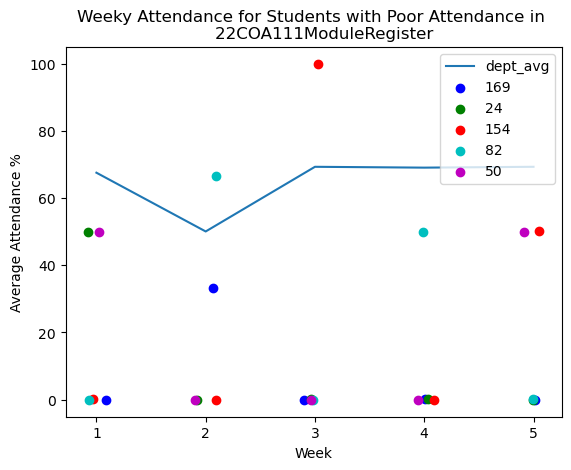

In [22]:
poor_att_vis = poor_att_graph(stu_random, module_code)